In [205]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Read in individual datasets for each state
all_states = os.listdir('clean_data/')
all_states = {f[:2]:pd.read_csv(f"clean_data/{f}") for f in all_states if len(f)<7}
print("Total number of states (including Federal Bureau of Prisons):", len(all_states.keys()))
all_states['MA']

Total number of states (including Federal Bureau of Prisons): 51


,name,abbreviation,staff_tests,prisoner_tests,total_staff_cases,total_prisoner_cases,total_staff_deaths,total_prisoner_deaths,date,week_num
0,Massachusetts,MA,NaN,NaN,4.0,9.0,0.0,0.0,2020-03-26,2020-13
1,Massachusetts,MA,NaN,NaN,7.0,20.0,0.0,0.0,2020-04-01,2020-14
2,Massachusetts,MA,NaN,NaN,26.0,46.0,0.0,3.0,2020-04-08,2020-15
3,Massachusetts,MA,NaN,NaN,42.0,90.0,0.0,4.0,2020-04-15,2020-16
4,Massachusetts,MA,NaN,296.0,93.0,127.0,0.0,7.0,2020-04-22,2020-17
5,Massachusetts,MA,NaN,747.0,120.0,257.0,0.0,7.0,2020-04-29,2020-18
6,Massachusetts,MA,NaN,1906.0,151.0,351.0,0.0,7.0,2020-05-06,2020-19


In [4]:
# Read in population data and fillna using OLS
pop = pd.read_csv('clean_data/population.csv')

# Fillin the nan values using a linear model
from sklearn.linear_model import LinearRegression
train = pop[pop['staff_pop']>0].copy()
test = pop[pop['staff_pop'].isna()].copy()
X_train, X_test, y_train = train[['prison_pop']], test[['prison_pop']], train['staff_pop']
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
y_pred = list(map(int, y_pred))
pop.loc[pop['staff_pop'].isnull(), 'staff_pop'] = y_pred
assert pop.isna().sum()['staff_pop'] == 0

### 1.Define 2 types of targets for OLS

In [7]:
# Define 2 types of targets for OLS
# 1. Percentage (in %) of for most recent cumulative prisoner/staff cases over prisoner/staff population
# 2. The slope of cumulative prisoner/staff cases

state_names = [c for c in list(all_states.keys()) if 'US' not in c]
result = {'state':[], 'prison_perc':[], 'staff_perc':[], 'prison_slope':[], 'staff_slope':[]}

for state in state_names:
    result['state'].append(state)
    state_df = all_states[state]
    # Normalize cases by population
    prisoner_pop = pop[pop['abbreviation'] == state]['prison_pop'].values[0]
    staff_pop = pop[pop['abbreviation'] == state]['staff_pop'].values[0]
    state_df['total_prisoner_cases'] /= prisoner_pop
    state_df['total_staff_cases'] /= staff_pop
    
    result['prison_perc'].append(state_df['total_prisoner_cases'].max() * 100)
    result['staff_perc'].append(state_df['total_staff_cases'].max() * 100)
    prison_slope = (state_df['total_prisoner_cases'].max() - state_df['total_prisoner_cases'].min()) / 7
    staff_slope = (state_df['total_staff_cases'].max() - state_df['total_staff_cases'].min()) / 7
    result['prison_slope'].append(prison_slope)
    result['staff_slope'].append(staff_slope)
result = pd.DataFrame(result)
result.head()

,state,prison_perc,staff_perc,prison_slope,staff_slope
0,MN,1.288218e-08,5.481190e-07,1.840311e-11,7.830271e-10
1,AZ,9.533525e-11,8.360652e-09,1.361932e-13,0.000000e+00
2,WA,4.928357e-10,5.125450e-09,7.040510e-13,6.485263e-12
3,WV,0.000000e+00,2.927690e-08,0.000000e+00,4.182414e-11
4,AL,8.451085e-11,6.933205e-09,1.207298e-13,9.321957e-12


### Policy data preprocessing

In [104]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [105]:
df_policy = pd.read_csv("data/policy_data.csv")
df_policy['state'] = df_policy['state'].map(lambda x: us_state_abbrev[x])
df_policy.head()

,state,webpage,tracker,visitation_suspended,legal_visitation_permitted,telephone_change,video_change,additional_change,Increased_hygiene,Screening_employees,Screening_admissions,Suspended_Transfers,Mandatory_isolation,Suspension_medical_copays,Expedited_parole,Reducing_staff,System_quarantine,Lockdown_facilities
0,AL,1,1,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN
1,AK,1,1,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,AZ,1,1,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
3,AR,1,1,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CA,1,1,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [106]:
df_policy = df_policy.fillna(0)
df_policy.describe()

,webpage,tracker,visitation_suspended,legal_visitation_permitted,telephone_change,video_change,additional_change,Increased_hygiene,Screening_employees,Screening_admissions,Suspended_Transfers,Mandatory_isolation,Suspension_medical_copays,Expedited_parole,Reducing_staff,System_quarantine,Lockdown_facilities
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.780000,0.680000,0.460000,0.520000,0.940000,0.360000,0.360000,0.740000,0.880000,0.580000,0.340000,0.320000,0.520000,0.320000,0.100000,0.100000,0.080000
std,0.418452,0.471212,0.503457,0.504672,0.239898,0.484873,0.484873,0.443087,0.328261,0.498569,0.478518,0.471212,0.504672,0.471212,0.303046,0.303046,0.274048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
dataset = df_policy.merge(result, on=['state'])
dataset.head()

,state,webpage,tracker,visitation_suspended,legal_visitation_permitted,telephone_change,video_change,additional_change,Increased_hygiene,Screening_employees,...,Mandatory_isolation,Suspension_medical_copays,Expedited_parole,Reducing_staff,System_quarantine,Lockdown_facilities,prison_perc,staff_perc,prison_slope,staff_slope
0,AL,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,8.451085e-11,6.933205e-09,1.207298e-13,9.321957e-12
1,AK,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,8.014417e-10,1.044793e-07,1.144917e-12,1.492561e-10
2,AZ,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,9.533525e-11,8.360652e-09,1.361932e-13,0.000000e+00
3,AR,1,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.570792e-08,1.918881e-07,2.243989e-11,2.741259e-10
4,CA,1,1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,2.393877e-11,1.736254e-10,3.411232e-14,2.348272e-13


In [161]:
x_state = dataset.iloc[:,:-4]

y_prison_perc = dataset['prison_perc']
y_staff_perc = dataset['staff_perc']
y_prison_slope = dataset['prison_slope']
y_staff_slope = dataset['staff_slope']

### 2.EDA on Policy

([<matplotlib.axis.XTick at 0x136ac2940>,
 <a list of 17 Text xticklabel objects>)

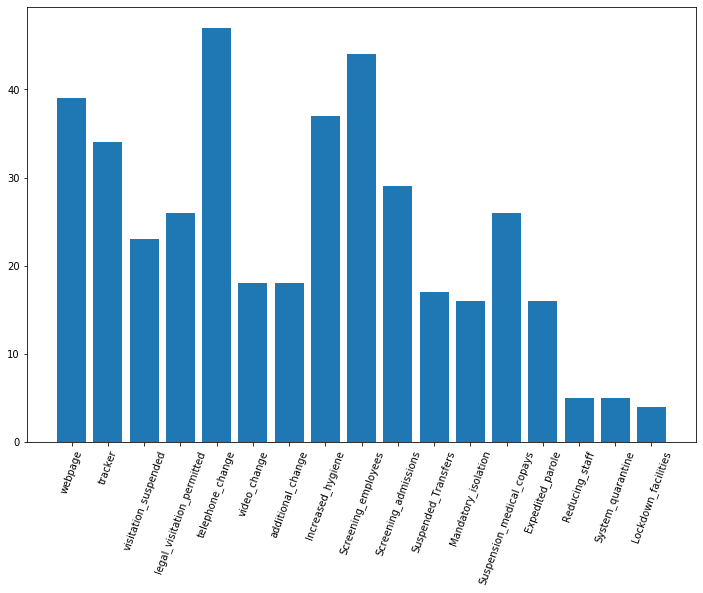

In [165]:
X_data = x_state.drop(['state'], axis=1)

count = []
for x in X_data:
    count.append(sum(X_data[x]))

plt.figure(figsize=(12,8))
plt.bar(range(len(X_data.columns.values)), count)
plt.xticks(range(len(X_data.columns.values)), list(X_data.columns.values), rotation=70)

### 3.Calculate VIF for colinearity

In [206]:
dataset_no_state = dataset.drop(['state'], axis=1)
features_list = list(dataset_no_state.columns)
features_list.remove('prison_perc')
features = "+".join(features_list)

# get y and X dataframes based on this regression:
y_matrix, x_matrix = dmatrices('prison_perc ~' + features, dataset_no_state, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_matrix.values, i) for i in range(x_matrix.shape[1])]
vif["features"] = x_matrix.columns

In [208]:
vif.round(3)

,VIF Factor,features
0,50.053,Intercept
1,2.022,webpage
2,1.573,tracker
3,21.538,visitation_suspended
4,20.447,legal_visitation_permitted
5,2.425,telephone_change
6,1.398,video_change
7,1.495,additional_change
8,2.258,Increased_hygiene
9,1.505,Screening_employees


### Check relationship of target variables

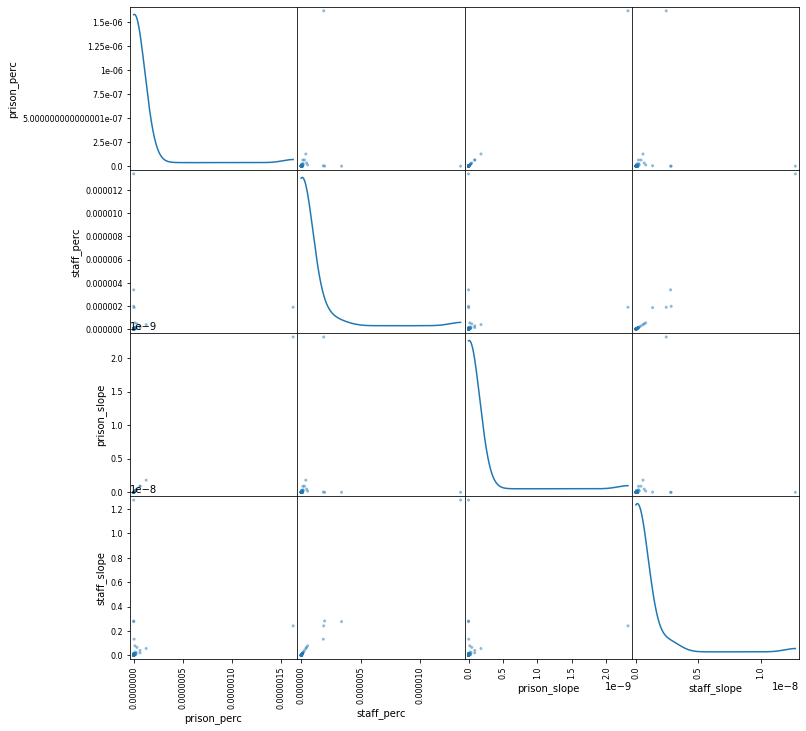

In [166]:
from pandas.plotting import scatter_matrix

y_variables = dataset.iloc[:,18:]
scatter_matrix(y_variables, figsize=(12,12), diagonal='kde')
plt.show()

## 4.OLS - linear regression

In [109]:
# E_x1 = x[y_prison_perc == 1].mean()
# E_x0 = x[y_prison_perc == 0].mean()
# V_x1 = x[y_prison_perc == 1].var()
# V_x0 = x[y_prison_perc == 0].var()
# n1 = len(x[y_prison_perc == 1])
# n0 = len(x[y_prison_perc == 0])
# t_value = abs(E_x1 - E_x0) / np.sqrt(V_x1/n1 + V_x0/n0)

In [110]:
# best_predictor = t_value.sort_values(ascending=False)[:10].index.values
# print("10 top discriminate polices:")
# for p in best_predictor:
#     print(p, end=' ')

In [167]:
X = sm.add_constant(X_data)
linear_regression1 = sm.OLS(y_prison_perc,X)
res1 = linear_regression1.fit()
res1.summary()

/Users/yuan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            prison_perc   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     1.931
Date:                Fri, 15 May 2020   Prob (F-statistic):             0.0529
Time:                        15:37:00   Log-Likelihood:                 711.73
No. Observations:                  50   AIC:                            -1387.
Df Residuals:                      32   BIC:                            -1353.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.079e-08   1.99e-07      0.105      0.917   -3.84e-07    4.26e-07
webpage                    -1.733e-08   8.89e-08     -0.195      0.847   -1.98e-07    1.64e-07
tracker                    -2.477e-08   7.54e-08     -0.329      0.745   -1.78e-07    1.29e-07
visitation_suspended        9.732e-08    2.6e-07      0.375      0.710   -4.32e-07    6.26e-07
legal_visitation_permitted -3.017e-08   2.54e-07     -0.119      0.906   -5.47e-07    4.87e-07
telephone_change           -1.391e-07    1.8e-07     -0.773      0.445   -5.06e-07    2.27e-07
video_change               -1.634e-08   6.76e-08     -0.242      0.811   -1.54e-07    1.21e-07
additional_change          -5.867e-08   6.83e-08     -0.859      0.397   -1.98e-07    8.04e-08
Increased_hygiene           1.569e-07   8.33e-08      1.885      0.069   -1.27e-08    3.27e-07
Screening_employees          1.52e-08   1.06e-07      0.143      0.887   -2.01e-07    2.31e-07
Screening_admissions       -6.582e-10   7.97e-08     -0.008      0.993   -1.63e-07    1.62e-07
Suspended_Transfers        -5.896e-08   7.24e-08     -0.814      0.422   -2.07e-07    8.86e-08
Mandatory_isolation         7.327e-08   9.17e-08      0.799      0.430   -1.14e-07     2.6e-07
Suspension_medical_copays  -8.908e-08    6.3e-08     -1.415      0.167   -2.17e-07    3.92e-08
Expedited_parole            1.744e-07   7.48e-08      2.333      0.026    2.21e-08    3.27e-07
Reducing_staff              -6.06e-08   1.09e-07     -0.556      0.582   -2.82e-07    1.61e-07
System_quarantine           1.607e-07   1.16e-07      1.386      0.175   -7.54e-08    3.97e-07
Lockdown_facilities         3.397e-07   1.24e-07      2.734      0.010    8.66e-08    5.93e-07
==============================================================================
Omnibus:                       42.047   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.470
Skew:                           1.953   Prob(JB):                     5.46e-51
Kurtosis:                      12.790   Cond. No.                         36.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

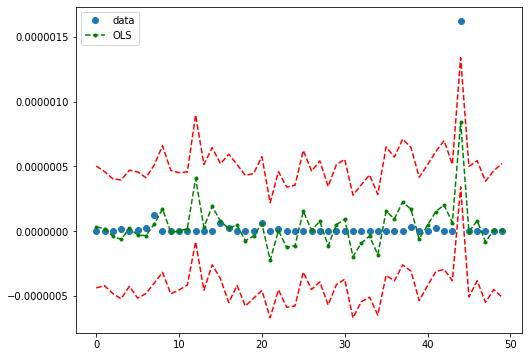

In [174]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(y_prison_perc, 'o', label="data")
ax.plot(res1.fittedvalues, 'g--.', label="OLS")
ax.plot(iv_u, 'r--')
ax.plot(iv_l, 'r--')
ax.legend(loc='best');

In [ ]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [77]:
linear_regression2 = sm.OLS(y_staff_perc,X)
res2 = linear_regression2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             staff_perc   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.041
Date:                Fri, 15 May 2020   Prob (F-statistic):              0.446
Time:                        11:41:21   Log-Likelihood:                 597.63
No. Observations:                  50   AIC:                            -1159.
Df Residuals:                      32   BIC:                            -1125.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.002e-07   1.95e-06      0.051      0.959   -3.87e-06    4.07e-06
webpage                     9.326e-08   8.71e-07      0.107      0.915   -1.68e-06    1.87e-06
tracker                    -4.041e-08   7.39e-07     -0.055      0.957   -1.54e-06    1.46e-06
visitation_suspended         6.46e-07   2.54e-06      0.254      0.801   -4.53e-06    5.83e-06
legal_visitation_permitted -1.052e-07   2.49e-06     -0.042      0.966   -5.17e-06    4.96e-06
telephone_change           -2.341e-08   1.76e-06     -0.013      0.989   -3.61e-06    3.57e-06
video_change                7.466e-07   6.62e-07      1.127      0.268   -6.03e-07     2.1e-06
additional_change           -1.07e-06   6.69e-07     -1.600      0.120   -2.43e-06    2.93e-07
Increased_hygiene          -1.007e-06   8.16e-07     -1.234      0.226   -2.67e-06    6.55e-07
Screening_employees         4.179e-07   1.04e-06      0.403      0.690    -1.7e-06    2.53e-06
Screening_admissions       -8.776e-07   7.81e-07     -1.124      0.269   -2.47e-06    7.13e-07
Suspended_Transfers         1.359e-06    7.1e-07      1.915      0.064   -8.62e-08     2.8e-06
Mandatory_isolation         1.508e-07   8.98e-07      0.168      0.868   -1.68e-06    1.98e-06
Suspension_medical_copays   8.383e-07   6.17e-07      1.359      0.184   -4.18e-07    2.09e-06
E1pedited_parole            8.915e-07   7.32e-07      1.217      0.232      -6e-07    2.38e-06
Reducing_staff             -1.455e-07   1.07e-06     -0.136      0.892   -2.32e-06    2.03e-06
System_quarantine          -1.286e-07   1.14e-06     -0.113      0.911   -2.44e-06    2.18e-06
Lockdown_ facilities        -5.53e-07   1.22e-06     -0.454      0.653   -3.03e-06    1.93e-06
==============================================================================
Omnibus:                       58.221   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              475.786
Skew:                           2.858   Prob(JB):                    4.83e-104
Kurtosis:                      16.989   Cond. No.                         36.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Decision Tree